# Proyek Klasifikasi Gambar: [Blood Cells]
- **Nama:** [Melina Kharisa]
- **Email:** [melinakharisa19@gmail.com]
- **ID Dicoding:** [MC229D5X0463]


## Import Semua Packages/Library yang Digunakan

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm.notebook import tqdm as tq
from collections import defaultdict


# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files

# Import libraries untuk spilt data
from sklearn.model_selection import train_test_split


In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_dir = "/content/drive/MyDrive/ML COBA COBA/CANDI"

total_files = 0
class_file_counts = defaultdict(int)

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            total_files += 1
            label = os.path.basename(root)
            class_file_counts[label] += 1

# Tampilkan hasil
print(f"Total file gambar di dataset: {total_files}\n")
print("Jumlah file per kelas:")
for label, count in sorted(class_file_counts.items()):
    print(f"- {label}: {count} file")


Total file gambar di dataset: 973

Jumlah file per kelas:
- Candi_Abang: 119 file
- Candi_Banyunibo: 168 file
- Candi_Barong: 179 file
- Candi_Borobudur: 379 file
- Candi_Bubrah: 128 file


### Data Preprocessing

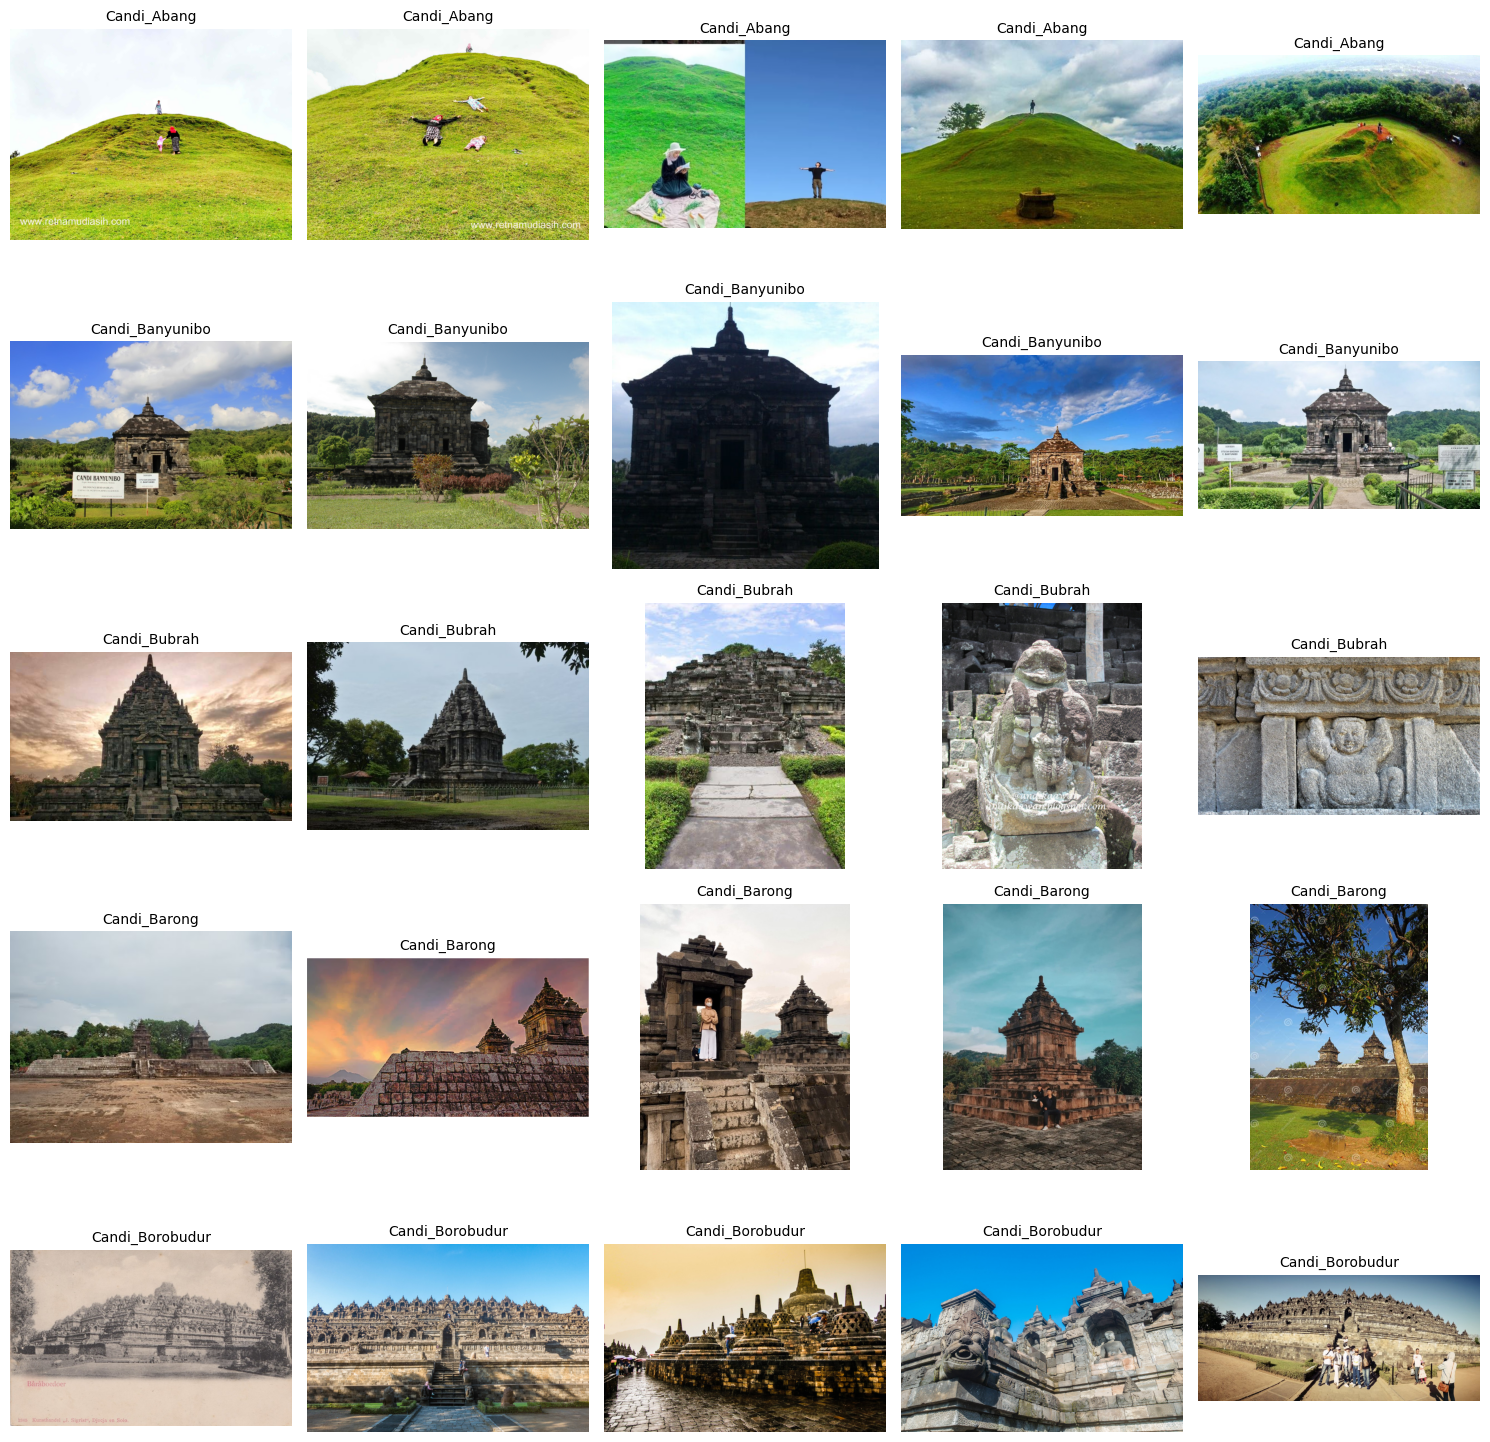

In [ ]:
# Membuat kamus yang menyimpan nama file gambar untuk setiap kelas
candi_image = {}

# Path langsung ke folder kelas
path_sub = "/content/drive/MyDrive/ML COBA COBA/CANDI"

# Loop untuk setiap kelas dan simpan nama filenya
for class_name in os.listdir(path_sub):
    class_path = os.path.join(path_sub, class_name)
    if os.path.isdir(class_path):
        candi_image[class_name] = os.listdir(class_path)

# Menampilkan 5 gambar acak dari setiap kelas
fig, axs = plt.subplots(len(candi_image), 5, figsize=(15, 3 * len(candi_image)))

for i, (class_name, file_list) in enumerate(candi_image.items()):
    selected_images = np.random.choice(file_list, 5, replace=False)

    for j, image_name in enumerate(selected_images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(class_name, fontsize=10)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()


Teridentifikasi 0 file yang berpotensi rusak:


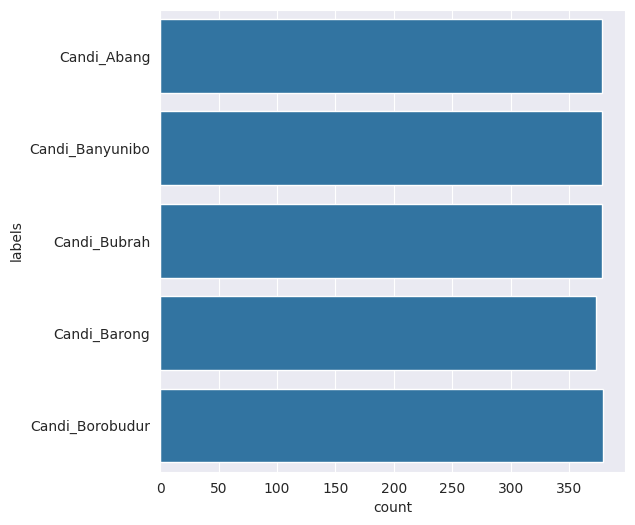

In [ ]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define source path
candi_path = "/content/drive/MyDrive/ML COBA COBA/CANDI"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
# Add error handling to identify corrupted files
corrupted_files = []
for path, subdirs, files in os.walk(candi_path):
    for name in files:
        file_full_path = os.path.join(path, name)
        # Lewati file yang bukan gambar berdasarkan ekstensi (opsional tapi disarankan)
        if not name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        try:
            # Attempt to open and load the image to check its integrity
            img = Image.open(file_full_path)
            img.verify() # Verify the file integrity
            # Jika verifikasi berhasil, tambahkan ke daftar
            full_path.append(file_full_path)
            labels.append(path.split('/')[-1])
            file_name.append(name)
        except Exception as e:
            print(f"Tidak dapat membuka atau memverifikasi file gambar: {file_full_path}. Error: {e}")
            corrupted_files.append(file_full_path)
            # Opsional: Jika Anda ingin mencoba memperbaiki file yang rusak dengan menyimpan ulang,
            # aktifkan blok try/except di bawah ini (hapus tanda # di depannya).
            # try:
            #     img = Image.open(file_full_path)
            #     img.save(file_full_path) # Coba perbaiki dengan menyimpan ulang
            #     print(f"Mencoba memperbaiki dan menyimpan ulang: {file_full_path}")
            #     full_path.append(file_full_path)
            #     labels.append(path.split('/')[-1])
            #     file_name.append(name)
            # except Exception as resave_e:
            #     print(f"Gagal memperbaiki dan menyimpan ulang: {file_full_path}. Error: {resave_e}")
            #     corrupted_files.append(file_full_path)


distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

print(f"\nTeridentifikasi {len(corrupted_files)} file yang berpotensi rusak:")
for cf in corrupted_files:
    print(cf)

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
# Helper untuk memastikan output valid
def finalize_image(img):
    img = img.numpy() if hasattr(img, 'numpy') else img  # convert dari tf.Tensor kalau perlu
    img = np.clip(img, 0, 255)
    img = img.astype(np.uint8)
    return img

def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))
    return finalize_image(img)

def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))
    return finalize_image(img)

def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return finalize_image(img)

def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))
    return finalize_image(img)

def blur_image(img):
    img = tf.image.resize(img, (224, 224))
    img = img.numpy() if hasattr(img, 'numpy') else img
    img = cv2.GaussianBlur(img, (3, 3), 0)
    return finalize_image(img)

def sheared(img):
    img = tf.image.resize(img, (224, 224))
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return finalize_image(img)

def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return finalize_image(img)

In [ ]:
from collections import defaultdict

root_path = "/content/drive/MyDrive/ML COBA COBA/CANDI"
classes = ['Candi_Abang', 'Candi_Banyunibo', 'Candi_Barong', 'Candi_Borobudur', 'Candi_Bubrah']
class_counts = {}

for cls in classes:
    class_path = os.path.join(root_path, cls)
    count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[cls] = count

print("Jumlah gambar per kelas:", class_counts)

Jumlah gambar per kelas: {'Candi_Abang': 380, 'Candi_Banyunibo': 380, 'Candi_Barong': 380, 'Candi_Borobudur': 380, 'Candi_Bubrah': 380}


In [ ]:
max_count = max(class_counts.values())

images_to_generate_per_class = {
    cls: max_count - count for cls, count in class_counts.items()
}

In [ ]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

root_path = "/content/drive/MyDrive/ML COBA COBA/CANDI"
augmented_suffix = "_augmented"

# Augmentasi per kelas
for cls in classes:
    images_path = os.path.join(root_path, cls)
    augmented_path = os.path.join(root_path, cls + augmented_suffix)

    os.makedirs(augmented_path, exist_ok=True)

    images = [os.path.join(images_path, im) for im in os.listdir(images_path)]

    to_generate = images_to_generate_per_class[cls]
    print(f"Augmenting class: {cls} | Need to generate: {to_generate}")

    i = 1
    while i <= to_generate:
        image = random.choice(images)
        try:
            original_image = io.imread(image)

            if original_image.ndim != 3:
                raise ValueError("Invalid image dimensions")

            transformed_image = original_image
            n = 0
            transformation_count = random.randint(1, len(transformations))

            while n <= transformation_count:
                key = random.choice(list(transformations))
                transformed_image = transformations[key](transformed_image)
                n += 1

            new_image_path = os.path.join(augmented_path, f"aug_{cls}_{i}.jpg")
            transformed_image = img_as_ubyte(transformed_image)
            cv2.imwrite(new_image_path, transformed_image)
            i += 1

        except Exception as e:
            print(f'Could not process image {image} : {e}, skipping.')

Augmenting class: Candi_Abang | Need to generate: 259
Could not process image /content/drive/MyDrive/ML COBA COBA/CANDI/Candi_Abang/Image_21.jpg : image file is truncated (28 bytes not processed), skipping.
Could not process image /content/drive/MyDrive/ML COBA COBA/CANDI/Candi_Abang/Image_21.jpg : image file is truncated (28 bytes not processed), skipping.
Could not process image /content/drive/MyDrive/ML COBA COBA/CANDI/Candi_Abang/Image_21.jpg : image file is truncated (28 bytes not processed), skipping.
Augmenting class: Candi_Banyunibo | Need to generate: 210
Could not process image /content/drive/MyDrive/ML COBA COBA/CANDI/Candi_Banyunibo/Image_133.gif : Invalid image dimensions, skipping.
Augmenting class: Candi_Barong | Need to generate: 194
Could not process image /content/drive/MyDrive/ML COBA COBA/CANDI/Candi_Barong/Image_166.gif : Invalid image dimensions, skipping.
Augmenting class: Candi_Borobudur | Need to generate: 0
Augmenting class: Candi_Bubrah | Need to generate: 25

In [ ]:
for cls in classes:
    original_folder = os.path.join(root_path, cls)
    augmented_folder = os.path.join(root_path, cls + "_augmented")

    # Cek apakah folder augmentasi ada
    if not os.path.exists(augmented_folder):
        print(f"Folder {augmented_folder} tidak ditemukan, lewati...")
        continue

    # Pindahkan semua file dari folder augmented ke folder asli
    for filename in os.listdir(augmented_folder):
        src = os.path.join(augmented_folder, filename)
        dst = os.path.join(original_folder, filename)

        # Rename otomatis kalau ada nama file yang sama
        if os.path.exists(dst):
            name, ext = os.path.splitext(filename)
            new_name = f"{name}_copy{ext}"
            dst = os.path.join(original_folder, new_name)

        shutil.move(src, dst)

    # Hapus folder augmented setelah dipindah semua
    shutil.rmtree(augmented_folder)
    print(f"Selesai gabung: {cls}")

Selesai gabung: Candi_Abang
Selesai gabung: Candi_Banyunibo
Selesai gabung: Candi_Barong
Selesai gabung: Candi_Borobudur
Selesai gabung: Candi_Bubrah


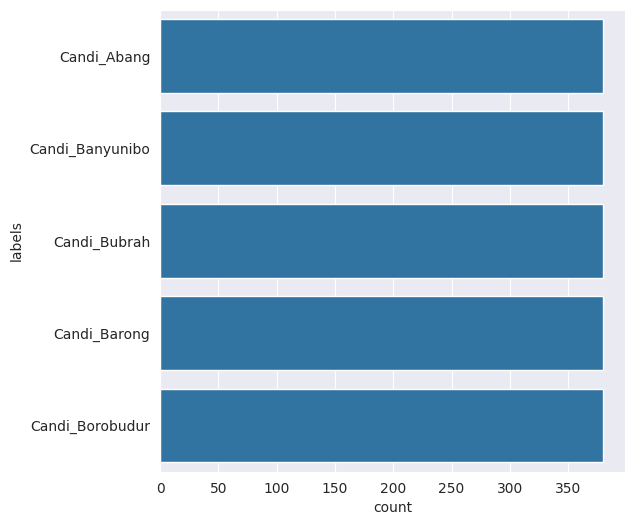

In [ ]:
# Define source path
candi_path = "/content/drive/MyDrive/ML COBA COBA/CANDI"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(candi_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= "/content/drive/MyDrive/ML COBA COBA/CANDI"

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Candi_Abang,380
Candi_Banyunibo,380
Candi_Barong,380
Candi_Borobudur,380
Candi_Bubrah,380


#### Split Dataset

In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 1520
test size 380


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels         
test   Candi_Abang         80
       Candi_Banyunibo     71
       Candi_Barong        80
       Candi_Borobudur     61
       Candi_Bubrah        88
train  Candi_Abang        300
       Candi_Banyunibo    309
       Candi_Barong       300
       Candi_Borobudur    319
       Candi_Bubrah       292
dtype: int64 


                                                   path        labels    set
1227  /content/drive/MyDrive/ML COBA COBA/CANDI/Cand...   Candi_Abang  train
1825  /content/drive/MyDrive/ML COBA COBA/CANDI/Cand...   Candi_Abang   test
1552  /content/drive/MyDrive/ML COBA COBA/CANDI/Cand...  Candi_Barong   test
1788  /content/drive/MyDrive/ML COBA COBA/CANDI/Cand...  Candi_Bubrah   test
895   /content/drive/MyDrive/ML COBA COBA/CANDI/Cand...  Candi_Barong  train


In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "/content/drive/MyDrive/ML COBA COBA/CANDI"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "/content/drive/MyDrive/ML COBA COBA/Dataset-Final"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
# Define training and test directories
TRAIN_DIR = "/content/drive/MyDrive/ML COBA COBA/Dataset-Final/train"
TEST_DIR = "/content/drive/MyDrive/ML COBA COBA/Dataset-Final/test"

train_Candi_Abang = os.path.join(TRAIN_DIR + '/Candi_Abang')
train_Candi_Banyunibo = os.path.join(TRAIN_DIR + '/Candi_Banyunibo')
train_Candi_Barong = os.path.join(TRAIN_DIR + '/Candi_Barong')
train_Candi_Borobudur = os.path.join(TRAIN_DIR + '/Candi_Borobudur')
train_Candi_Bubrah = os.path.join(TRAIN_DIR + '/Candi_Bubrah')

test_Candi_Abang = os.path.join(TEST_DIR + '/Candi_Abang')
test_Candi_Banyunibo = os.path.join(TEST_DIR + '/Candi_Banyunibo')
test_Candi_Barong = os.path.join(TEST_DIR + '/Candi_Barong')
test_Candi_Borobudur = os.path.join(TEST_DIR + '/Candi_Borobudur')
test_Candi_Bubrah = os.path.join(TEST_DIR + '/Candi_Bubrah')

print("Total number of Candi Abang images in training set: ",len(os.listdir(train_Candi_Abang)))
print("Total number of Candi Banyunibo images in training set: ",len(os.listdir(train_Candi_Banyunibo)))
print("Total number of Candi Barong images in training set: ",len(os.listdir(train_Candi_Barong)))
print("Total number of Candi Borobudur in training set: ",len(os.listdir(train_Candi_Borobudur)))
print("Total number of Candi Bubrah images in training set: ",len(os.listdir(train_Candi_Bubrah)))

print("Total number of Candi Abang images in test set: ",len(os.listdir(test_Candi_Abang)))
print("Total number of Candi Banyunibo images in test set: ",len(os.listdir(test_Candi_Banyunibo)))
print("Total number of Candi Barong images in test set: ",len(os.listdir(test_Candi_Barong)))
print("Total number of Candi Borobudur images in test set: ",len(os.listdir(test_Candi_Borobudur)))
print("Total number of Candi Bubrah images in test set: ",len(os.listdir(test_Candi_Bubrah)))

Total number of Candi Abang images in training set:  300
Total number of Candi Banyunibo images in training set:  309
Total number of Candi Barong images in training set:  300
Total number of Candi Borobudur in training set:  319
Total number of Candi Bubrah images in training set:  292
Total number of Candi Abang images in test set:  80
Total number of Candi Banyunibo images in test set:  71
Total number of Candi Barong images in test set:  80
Total number of Candi Borobudur images in test set:  61
Total number of Candi Bubrah images in test set:  88


In [ ]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(224,224),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(224,224),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(224,224),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 1208 images belonging to 5 classes.
Found 300 images belonging to 5 classes.
Found 379 images belonging to 5 classes.


## Modelling

In [ ]:
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model= Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(64, (4, 4), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# Global Average Pooling
model.add(Flatten())

# 1st Dense Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# 2nd Dense Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(5, activation='softmax'))

# Compile
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Summary
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 112, 112, 64)   │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 32)     │       100,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,574,181 (25.08 MB)

 Trainable params: 6,573,925 (25.08 MB)

 Non-trainable params: 256 (1.00 KB)

None


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback

class StopAtThreshold(Callback):
    def __init__(self, acc_threshold=0.80, val_acc_threshold=0.80):
        super(StopAtThreshold, self).__init__()
        self.acc_threshold = acc_threshold
        self.val_acc_threshold = val_acc_threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")
        if acc is not None and val_acc is not None:
            if acc >= self.acc_threshold and val_acc >= self.val_acc_threshold:
                print(f"\n🛑 Stopping training: accuracy={acc:.2f}, val_accuracy={val_acc:.2f}")
                self.model.stop_training = True

In [ ]:
train_dir = TRAIN_DIR  # "Dataset-Final/train/"
class_names = sorted(os.listdir(train_dir))

# Hitung jumlah sample tiap kelas
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}

# Total sample dan jumlah kelas
total = sum(class_counts.values())
num_classes = len(class_counts)

# Hitung class weights
class_weights = {}
class_indices = {cls: idx for idx, cls in enumerate(class_names)}

for cls, count in class_counts.items():
    idx = class_indices[cls]
    class_weights[idx] = (1 / count) * (total / num_classes)

print("Class Weights:", class_weights)
# Inisialisasi custom callback
stop_callback = StopAtThreshold(acc_threshold=0.80, val_acc_threshold=0.80)

# Training model dengan callback custom
history = model.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[stop_callback]
)

Class Weights: {0: 1.0133333333333334, 1: 0.9838187702265373, 2: 1.0133333333333334, 3: 0.9529780564263323, 4: 1.0410958904109588}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 677ms/step - accuracy: 0.2670 - loss: 8.0641 - val_accuracy: 0.1900 - val_loss: 3.5783
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 373ms/step - accuracy: 0.3465 - loss: 5.4052 - val_accuracy: 0.2067 - val_loss: 3.2647
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 382ms/step - accuracy: 0.3413 - loss: 3.0152 - val_accuracy: 0.2633 - val_loss: 1.6542
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 376ms/step - accuracy: 0.3386 - loss: 2.0626 - val_accuracy: 0.2467 - val_loss: 1.5886
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 376ms/step - accuracy: 0.3520 - loss: 1.7310 - val_accuracy: 0.3133 - val_loss: 1.4288
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 377ms/step - accuracy: 0.3325 - loss: 1.7053 - val_accuracy: 0.2067 - val_loss: 2.6091
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 382ms/step - accuracy: 0.3429 - loss: 1.5968 - val_accuracy: 0.3500 - val_loss: 1.5302
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 378ms/step - accuracy: 0.3691 - loss: 1.5220 - val_accu

## Evaluasi dan Visualisasi

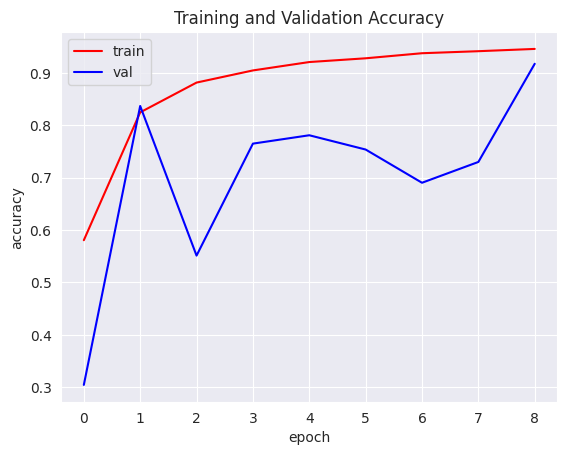

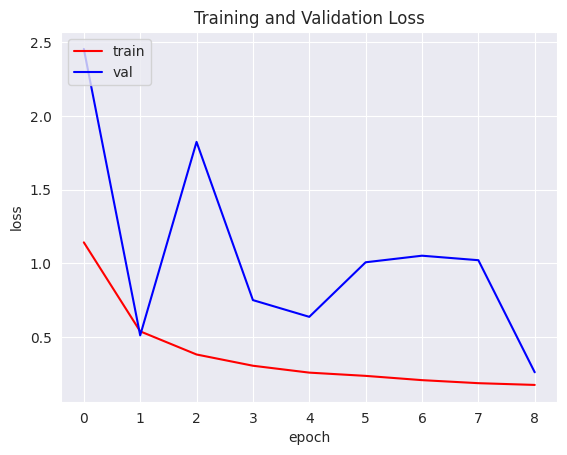

In [ ]:
# Mengambil nilai akurasi dan loss dari hasil training model
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Mendefinisikan jumlah epoch berdasarkan panjang history
epochs = range(len(acc))

# Menampilkan grafik akurasi
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Menampilkan grafik loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

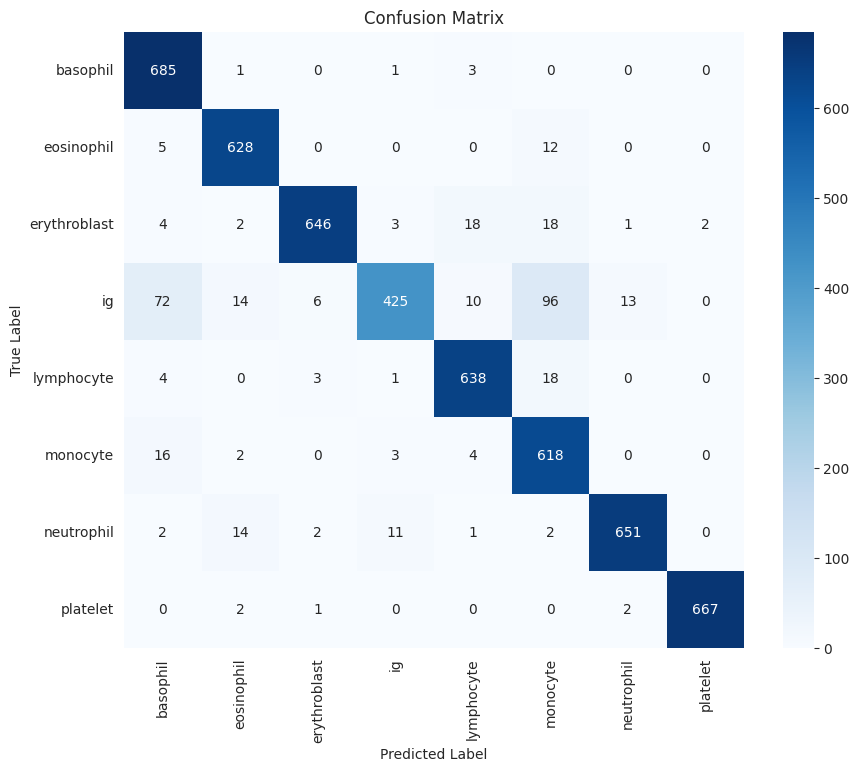


Classification Report:

              precision    recall  f1-score   support

    basophil     0.8693    0.9928    0.9269       690
  eosinophil     0.9472    0.9736    0.9602       645
erythroblast     0.9818    0.9308    0.9556       694
          ig     0.9572    0.6682    0.7870       636
  lymphocyte     0.9466    0.9608    0.9537       664
    monocyte     0.8089    0.9611    0.8785       643
  neutrophil     0.9760    0.9531    0.9644       683
    platelet     0.9970    0.9926    0.9948       672

    accuracy                         0.9307      5327
   macro avg     0.9355    0.9291    0.9276      5327
weighted avg     0.9360    0.9307    0.9289      5327



In [ ]:
# Reset test generator agar prediksi dimulai dari awal
test_generator.reset()

# Prediksi model (output probabilitas per kelas)
preds = model.predict(test_generator, verbose=0)

# Ambil prediksi kelas (dengan argmax karena ini multi-class)
predicted_classes = np.argmax(preds, axis=1)

# Ground truth label
true_classes = test_generator.classes

# Label nama kelas (urutannya sama dengan class_indices)
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4))

## Konversi Model

In [ ]:
#simpan model dalam format saved model
model.export("saved_model/my_model")

Saved artifact at 'saved_model/my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  133620663340496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133620663342608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133620663352208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133620663344528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133620663344720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133620663346064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133620663349328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133620663347216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133620663351248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133620663345488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1336206633

In [ ]:
#simpan model dalam format tflite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/my_model")
tflite_model = converter.convert()

with open("my_model.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
#simpan model dalam format tfjs
!pip install tensorflowjs

# Convert dari SavedModel
!tensorflowjs_converter --input_format=tf_saved_model \
                        --output_node_names='dense_2/Softmax' \
                        --saved_model_tags=serve \
                        saved_model/my_model tfjs_model/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-16 04:25:51.329707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744777551.349775   11553 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

In [ ]:
# membuat file label.txt
with open("label.txt", "w") as f:
    for label in class_names:
        f.write(label + "\n")

print("✅ File label.txt berhasil dibuat!")

✅ File label.txt berhasil dibuat!


In [ ]:
!pip freeze > requirements.txt

## Inference (Optional)